In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import os
import torch.nn.init as init
import json

from image_import_module import ImageDataset, get_subdirectories
from torch.utils.data import ConcatDataset, DataLoader
from torch.utils.data import random_split
from modules/conformer import Conformer



cuda = torch.cuda.is_available()  
if cuda:
    print('cuda is available')
else:
    print('cuda is not available')
device = torch.device('cuda' if cuda else 'cpu')

cuda is not available


In [16]:
'''
Combining the training data from all the subdirectories into one big dataset
Then use DataLoader to create batches of data
'''

list_of_subdirectories = get_subdirectories('./train_images')

# idx_to_name = {}
# name_to_idx = {}

# for i, path in enumerate(list_of_subdirectories):
#     idx_to_name[i] = path.split('/')[-1]
#     name_to_idx[path.split('/')[-1]] = i

list_of_datasets = []

with open('name_to_idx.json', 'r') as f:
    name_to_idx =json.load(f)

with open('idx_to_name.json', 'r') as f:
    idx_to_name = json.load(f)

for i, path in enumerate(list_of_subdirectories):
    current_dataset = ImageDataset(name_to_idx, path)#, transform=normalize_transform)    
    list_of_datasets.append(current_dataset)

    
complete_dataset = ConcatDataset(list_of_datasets)

# Splitting the dataset into training and development sets
train_size = int(0.95 * len(complete_dataset))
dev_size = len(complete_dataset) - train_size

train_dataset, dev_dataset = random_split(complete_dataset, [train_size, dev_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=True, num_workers=4)




In [17]:
bird_classifier = Conformer(num_classes=182,input_channels=4,input_height=224, input_length=224, conv_kernel_size=5, num_heads=5, num_conformer_blocks=6,  subsampling_factor=2, device=device).to(device) 

# for param in bird_classifier.parameters():
#     if len(param.shape) > 1:
#         init.kaiming_normal_(param)
#     else:
#         init.constant_(param, 0)



In [5]:
epochs = 1
learning_rate = 0.02
from_save = False 

torch.Size([4, 224, 224])


In [8]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(bird_classifier.parameters(), lr=learning_rate)  


In [9]:
if from_save:
    bird_classifier.load_state_dict(torch.load('bird_classifier_epoch_3.pth'))
    

for t in range(epochs):
    array_of_losses = np.array([]) 
    for data, labels in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        labels = labels.to(device)
        output = bird_classifier(data)
        loss_val = loss(output, labels)
        loss_val.backward()

        optimizer.step() 
        array_of_losses = np.append(array_of_losses, loss_val.item())
        print(loss_val.item())

    filename = 'results/bird_classifier_epoch_' + str(t) + '.pth'
    torch.save(bird_classifier.state_dict(), filename)
    lossesname = 'results/losses_epoch_' + str(t) + '.npy'
    np.save(lossesname, array_of_losses)
    

Gradient norm: 17.688240349275855
5.2518839836120605
Gradient norm: 170.3462423084914
28.246030807495117
Gradient norm: 176.24072805087008
196.06085205078125
Gradient norm: 3252.4704908741014
294.1779479980469
Gradient norm: 146.89066501397724
457.1192932128906
Gradient norm: 152.8181320419439
409.8251647949219
Gradient norm: 55590.1844980843
346.9348449707031
Gradient norm: 644.0013733588504
1119.4267578125
Gradient norm: 2902.8092364623076
801.874267578125
Gradient norm: 317.4805669054656
319.115966796875


KeyboardInterrupt: 

In [ ]:
losses = np.load('losses_epoch_9.npy')
rolling_average = np.convolve(losses, np.ones(100)/100, mode='valid')


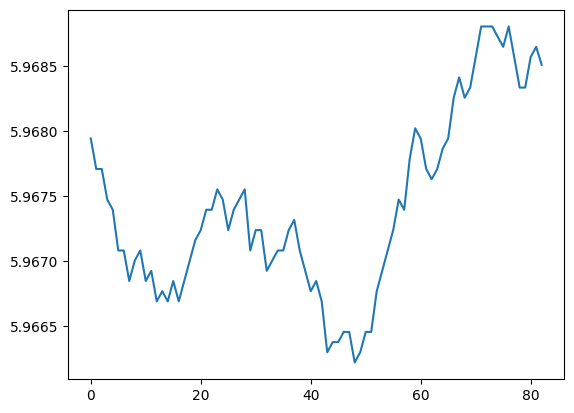

In [ ]:
plt.plot(rolling_average)
plt.show()

In [18]:
bird_classifier.load_state_dict(torch.load('bird_classifier_epoch_25.pth', map_location=torch.device('cpu')))



<All keys matched successfully>

In [19]:


bird_classifier.eval()
num_total = 0
num_correct =0
for data, labels in dev_loader:
    yhat = bird_classifier(data)
    pred = torch.argmax(yhat, dim =-1)
    num_correct +=torch.sum(pred==labels)
    num_total +=len(labels)
   
print(f" accuracy is {num_correct/num_total}")

tensor([ 10,   5, 158,  14, 172])
tensor([ 10,   5, 158,  14, 172])
 accuracy is 0.9559835195541382


In [20]:
print(pred[:10])
print(labels[:10])

tensor([ 10,   5, 158,  14, 172,  44, 167, 128,   9,  92])
tensor([ 10,   5, 158,  14, 172, 152, 167, 128,   9,  92])


In [8]:
test_data, test_label= dev_dataset[0]
test_pred = bird_classifier(test_data.unsqueeze(0))
print(torch.argmax(test_pred))
print(test_label)

tensor([[ 2.6688e+00, -3.6213e+00,  4.2404e-01, -1.5229e+00, -2.2089e+00,
          3.2281e+00,  5.5662e-01, -5.2886e+00,  1.1971e+00,  2.8911e+00,
         -1.7808e+00, -5.1851e-01,  1.4792e+00, -2.2105e+00, -1.7621e+00,
          4.2274e+00, -3.2314e+00,  2.7263e+00, -4.4635e-01,  1.4726e+00,
          2.4972e+00,  2.4701e-01,  4.4018e+00,  1.6960e+00,  6.3031e+00,
          1.4230e+00, -9.0394e-01, -1.8081e+00,  1.2289e+00,  1.3777e+01,
          1.1879e+00, -5.4271e-01, -3.0012e-01, -3.4140e+00,  3.0783e+00,
         -4.8272e+00,  3.8403e+00, -1.0193e+00, -2.1492e+00, -2.3508e+00,
          3.9198e+00,  4.8330e-01, -1.3981e+00, -1.1474e+00,  1.2014e+00,
         -4.5324e+00, -3.3938e+00, -1.9376e-01, -1.2139e-01, -2.5691e+00,
          5.0117e-01, -1.3611e+00, -3.0488e+00, -2.0327e+00, -1.0362e-01,
         -3.5768e+00, -2.1918e-01, -2.6236e+00,  9.9088e-01, -4.4599e+00,
          2.5181e+00, -4.8871e+00, -3.0227e+00,  3.5508e+00, -1.7184e+00,
         -2.7832e-01, -4.7847e+00, -7.